# OBJECT DETECTION

In [1]:
!pip install ultralytics --quiet

from ultralytics import YOLO
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00:00:0100:01
Creating new Ultral

## Downloading the Dataset 

In [2]:
%cd /kaggle/working

!mkdir -p coco
%cd coco

# val2017 images + annotations (5k images)
!wget -q http://images.cocodataset.org/zips/val2017.zip
!wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip

!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

/kaggle/working
/kaggle/working/coco


# Exploring the dataset

In [ ]:
import os, json

ann_file = "/kaggle/working/coco/annotations/instances_val2017.json"

with open(ann_file, "r") as f:
    coco_data = json.load(f)

images = coco_data["images"]
annotations = coco_data["annotations"]
categories = coco_data["categories"]

print("Number of images:", len(images))       
print("Number of annotations:", len(annotations))
print("Number of categories:", len(categories))


Number of images: 5000
Number of annotations: 36781
Number of categories: 80


In [8]:
cat_map = {c["id"]: c["name"] for c in categories}
print("All categories:", list(cat_map.values())[:80])


All categories: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


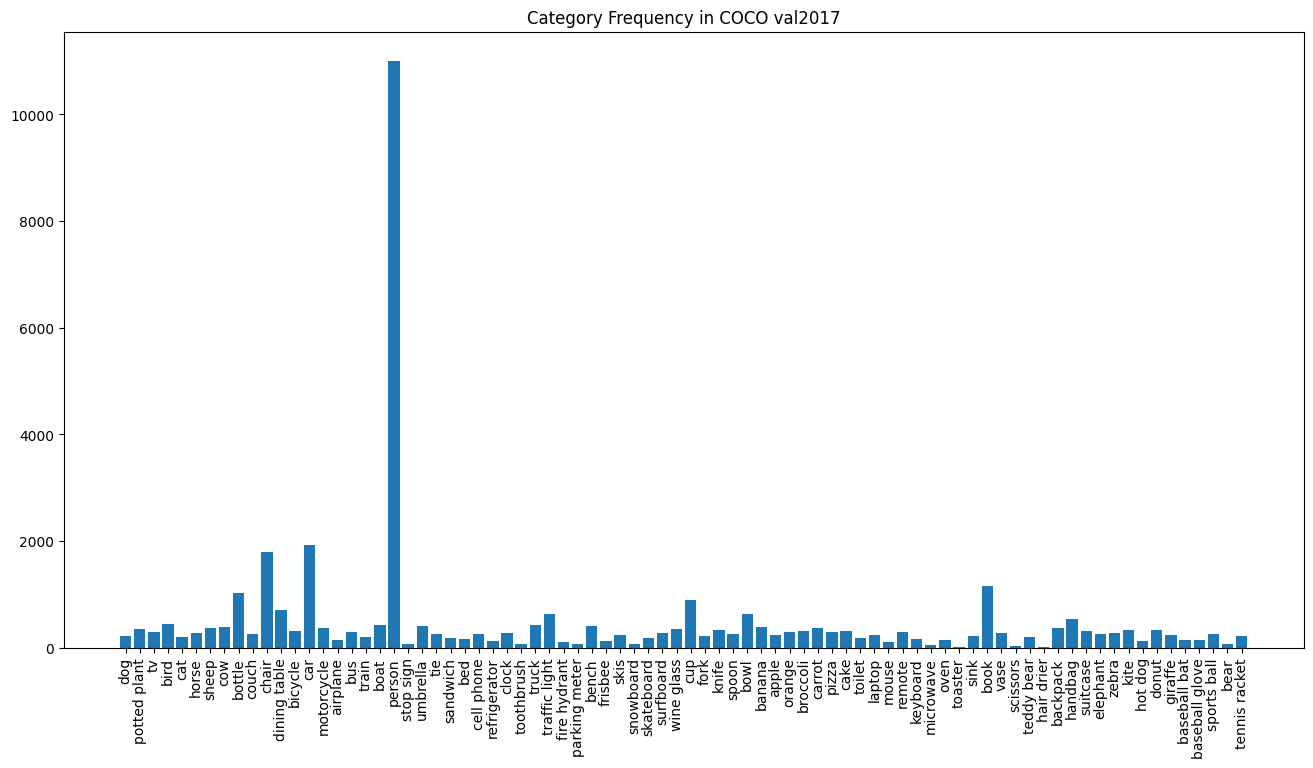

In [11]:
import collections
import matplotlib.pyplot as plt

# Count number of annotations per category
cat_counts = collections.Counter([ann["category_id"] for ann in annotations])
cat_names = [cat_map[cid] for cid in cat_counts.keys()]
counts = list(cat_counts.values())

plt.figure(figsize=(16,8))
plt.bar(cat_names, counts)
plt.xticks(rotation=90)
plt.title("Category Frequency in COCO val2017")
plt.show()


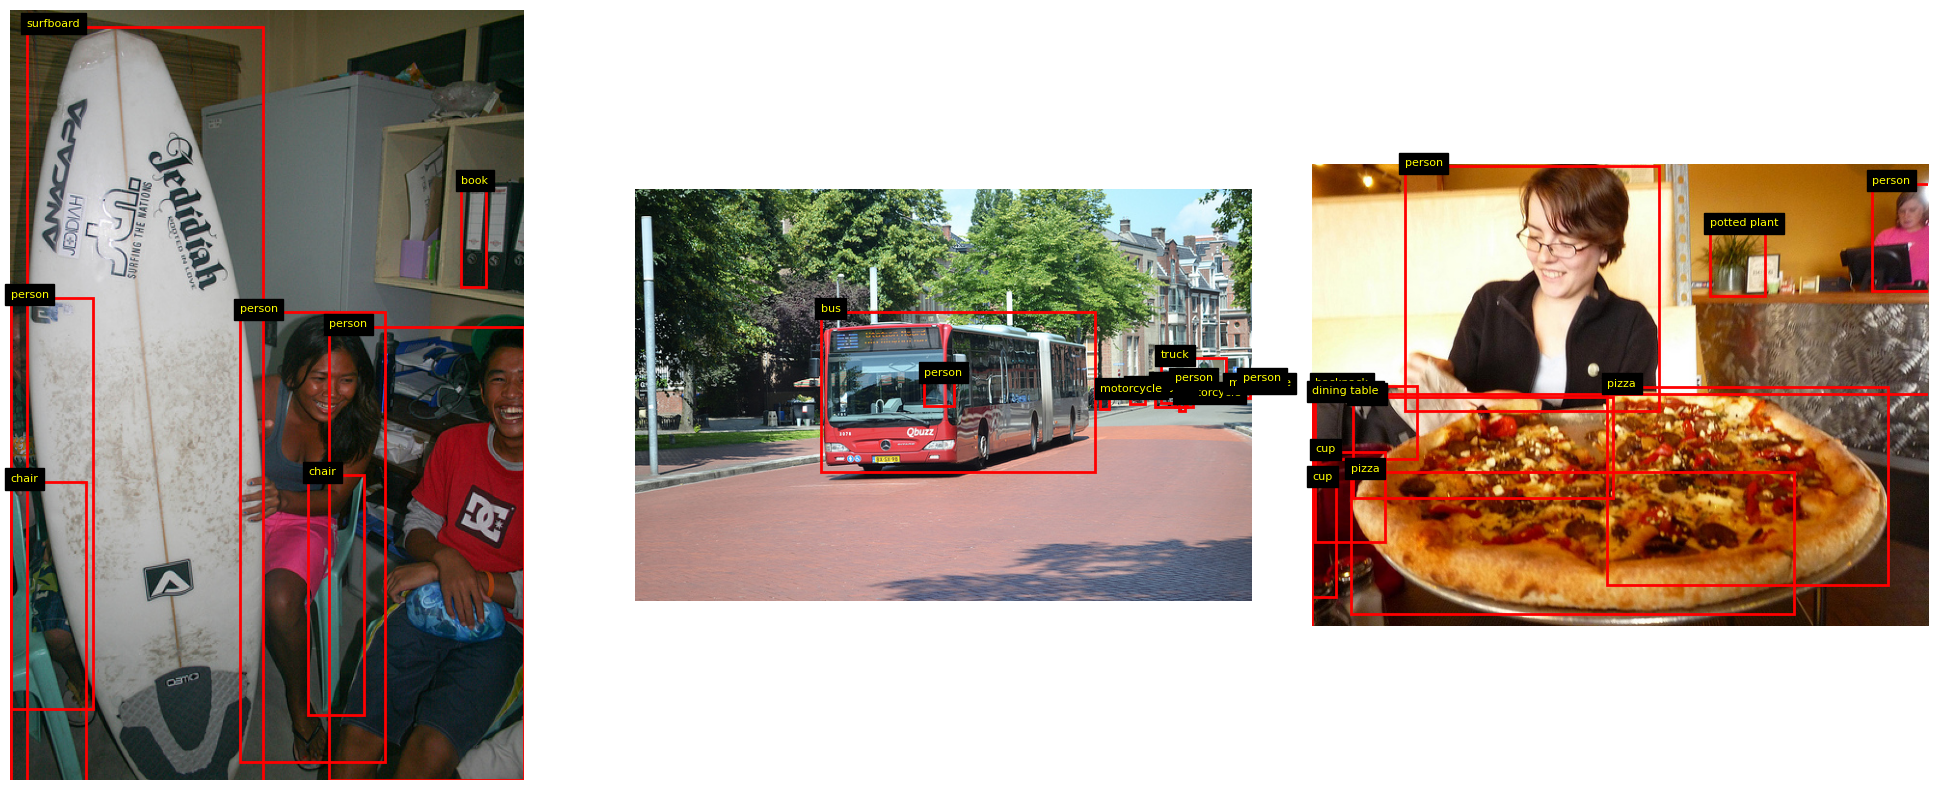

In [16]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

samples = random.sample(images, 3)

fig, axs = plt.subplots(1, 3, figsize=(20, 8))

for ax, sample in zip(axs, samples):
    img_id = sample["id"]
    img_path = os.path.join("/kaggle/working/coco/val2017", sample["file_name"])

    anns = [a for a in annotations if a["image_id"] == img_id]

    img = Image.open(img_path)
    ax.imshow(img)

    # draw boxes
    for ann in anns:
        x, y, w, h = ann["bbox"]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        cat = cat_map[ann["category_id"]]
        ax.text(x, y, cat, color='yellow', fontsize=8, backgroundcolor="black")

    ax.axis("off")

plt.tight_layout()
plt.show()



## Pre processing 

In [ ]:
import os, json, random, shutil
from pathlib import Path
from collections import defaultdict
from PIL import Image

random.seed(42)

# === Paths ===
SRC_IMG = "/kaggle/working/coco/val2017"
ANN_FILE = "/kaggle/working/coco/annotations/instances_val2017.json"
ROOT = "/kaggle/working/coco_person"

# target dirs
train_img_dir = os.path.join(ROOT, "images", "train")
val_img_dir   = os.path.join(ROOT, "images", "val")
train_lbl_dir = os.path.join(ROOT, "labels", "train")
val_lbl_dir   = os.path.join(ROOT, "labels", "val")

for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# === Load COCO annotations ===
with open(ANN_FILE, "r") as f:
    coco = json.load(f)

imgs = coco["images"]
anns = coco["annotations"]
cats = coco["categories"]

# Person class id in COCO JSON
PERSON_CAT_ID = 1

# Group annotations per image (only persons)
per_image = defaultdict(list)
for a in anns:
    if a["category_id"] == PERSON_CAT_ID:
        per_image[a["image_id"]].append(a)

# Get only images that have at least one person
person_imgs = [im for im in imgs if im["id"] in per_image]
all_imgs = [im["file_name"] for im in person_imgs]
print(f"Total person images: {len(all_imgs)}")

# === Split images (only positive) ===
random.shuffle(all_imgs)
split_idx = int(0.8 * len(all_imgs))
train_imgs, val_imgs = all_imgs[:split_idx], all_imgs[split_idx:]

for fn in train_imgs:
    shutil.copy(os.path.join(SRC_IMG, fn), os.path.join(train_img_dir, fn))
for fn in val_imgs:
    shutil.copy(os.path.join(SRC_IMG, fn), os.path.join(val_img_dir, fn))

print(f"Train imgs: {len(train_imgs)}, Val imgs: {len(val_imgs)}")

# === Generate YOLO labels ===
def gen_labels(img_list, img_dir, lbl_dir):
    written = 0
    for fname in img_list:
        img = next(im for im in imgs if im["file_name"] == fname)
        anns = per_image.get(img["id"], [])
        if not anns:
            continue  
        W, H = img["width"], img["height"]
        lines = []
        for a in anns:
            x,y,w,h = a["bbox"]
            xc = (x + w/2) / W
            yc = (y + h/2) / H
            wn = w / W
            hn = h / H
            lines.append(f"0 {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")
        with open(os.path.join(lbl_dir, Path(fname).stem + ".txt"), "w") as f:
            f.write("\n".join(lines))
        written += 1
    return written

t_written = gen_labels(train_imgs, train_img_dir, train_lbl_dir)
v_written = gen_labels(val_imgs, val_img_dir, val_lbl_dir)

print(f"Labels written -> train: {t_written}, val: {v_written}")



Total person images: 2693
Train imgs: 2154, Val imgs: 539
Labels written -> train: 2154, val: 539


In [4]:
yaml_text = f"""
path: {ROOT}
train: images/train
val: images/val
nc: 1
names: [person]
"""
with open("/kaggle/working/person.yaml", "w") as f:
    f.write(yaml_text)

In [5]:
model = YOLO("yolov8l.pt")

model.train(
    data="/kaggle/working/person.yaml",
    epochs=100,
    imgsz=640,
    batch=16,
    workers=2,
)


Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/person.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        539       2301      0.773      0.591      0.682      0.445
Speed: 0.2ms preprocess, 14.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/coco/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x791ca66f7f10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
metrics = model.val()
print(metrics)


Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3055.0±693.7 MB/s, size: 174.2 KB)
val: Scanning /kaggle/working/coco_person/labels/val.cache... 539 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 539/539 1.1Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 34/34 1.8it/s 19.1s0.5s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        539       2301       0.77      0.589       0.68      0.446
Speed: 0.5ms preprocess, 31.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/coco/runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x791c8448f2d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,

Using run: /kaggle/working/coco/runs/detect/train2


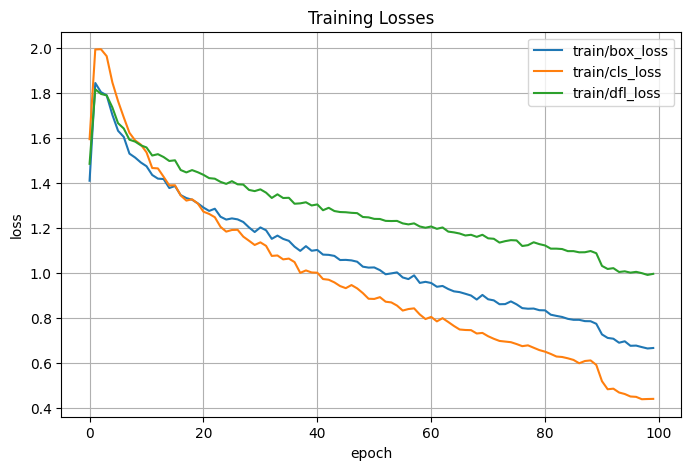

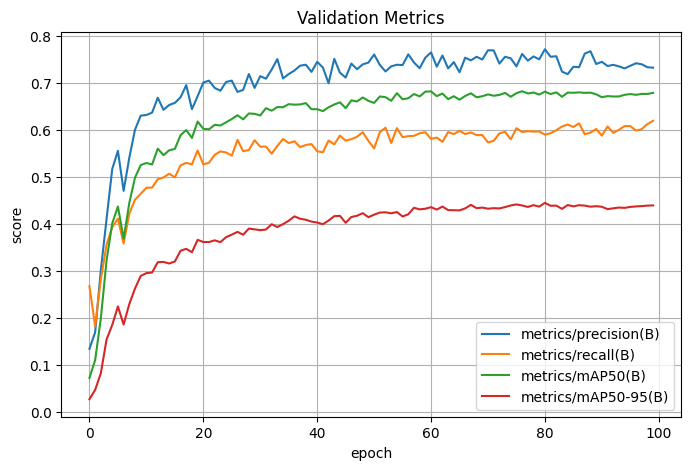

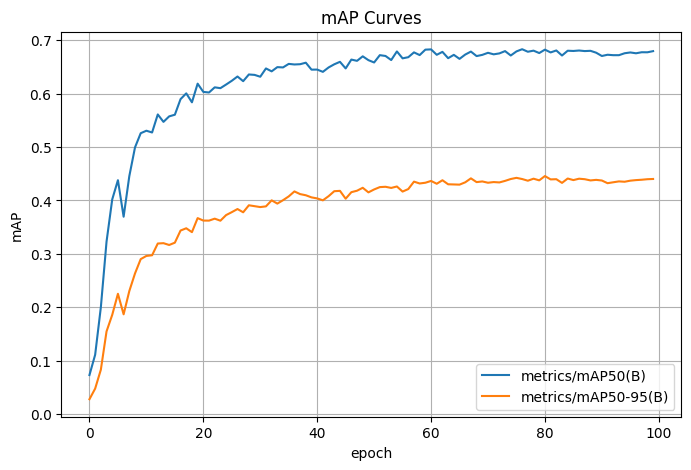

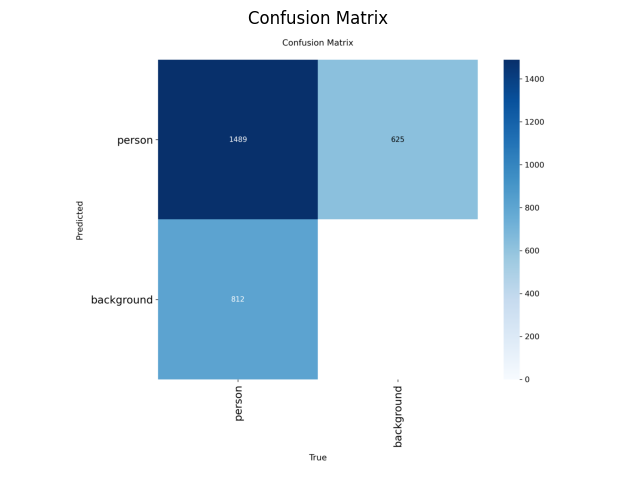


Final epoch metrics:
  metrics/precision(B): 0.7333
  metrics/recall(B): 0.6202
  metrics/mAP50(B): 0.6795
  metrics/mAP50-95(B): 0.4401


In [ ]:
import os, glob, csv
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Find latest run directory
def latest_run(base="/kaggle/working/coco/runs/detect"):
    exps = sorted(glob.glob(os.path.join(base, "train*")), key=os.path.getmtime)
    if not exps:
        raise FileNotFoundError(f"No runs found under {base}.")
    return exps[-1]

run_dir = latest_run("/kaggle/working/coco/runs/detect")
print("Using run:", run_dir)

# # Load results.csv 
# csv_path = os.path.join(run_dir, "results.csv")
# if not os.path.exists(csv_path):
#     raise FileNotFoundError(f"results.csv not found in {run_dir}")
df = pd.read_csv("/kaggle/working/coco/runs/detect/train/results.csv")

# Simple helper to make a plot
def plot_series(df, cols, title, ylabel):
    plt.figure(figsize=(8,5))
    for c in cols:
        if c in df.columns:
            plt.plot(df.index, df[c], label=c)
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot core curves
# Losses (training)
loss_cols = [c for c in ["train/box_loss","train/cls_loss","train/dfl_loss","box_loss","cls_loss","dfl_loss"] if c in df.columns]
if loss_cols:
    plot_series(df, loss_cols, "Training Losses", "loss")

# Validation metrics
val_cols = [c for c in ["metrics/precision(B)","metrics/recall(B)","metrics/mAP50(B)","metrics/mAP50-95(B)",
                        "precision","recall","mAP50","mAP50-95"] if c in df.columns]
if val_cols:
    plot_series(df, val_cols, "Validation Metrics", "score")

# mAPs explicitly 
map_cols = [c for c in ["metrics/mAP50(B)","metrics/mAP50-95(B)","mAP50","mAP50-95"] if c in df.columns]
if map_cols:
    plot_series(df, map_cols, "mAP Curves", "mAP")

# Ultralytics’ generated summary images if present
def show_if_exists(path, title=None, size=(8,6)):
    if os.path.exists(path):
        img = Image.open(path)
        plt.figure(figsize=size)
        plt.imshow(img); plt.axis("off")
        if title: plt.title(title)
        plt.show()

show_if_exists(os.path.join(run_dir, "results.png"), "Ultralytics Results Summary")
show_if_exists(os.path.join(run_dir, "PR_curve.png"), "Precision–Recall Curve")
show_if_exists(os.path.join(run_dir, "F1_curve.png"), "F1 Curve")
show_if_exists(os.path.join(run_dir, "P_curve.png"), "Precision Curve")
show_if_exists(os.path.join(run_dir, "R_curve.png"), "Recall Curve")
show_if_exists(os.path.join(run_dir, "confusion_matrix.png"), "Confusion Matrix")

last = df.iloc[-1]
keys = [k for k in ["metrics/precision(B)","metrics/recall(B)","metrics/mAP50(B)","metrics/mAP50-95(B)",
                    "precision","recall","mAP50","mAP50-95"] if k in df.columns]
print("\nFinal epoch metrics:")
for k in keys:
    print(f"  {k}: {last[k]:.4f}")


In [10]:
import shutil

best = "runs/detect/train/weights/best.pt"  
dst = "/kaggle/working/yolov8_person_best.pt"
shutil.copy(best, dst)
print(f"✅ Saved best weights to {dst}")

✅ Saved best weights to /kaggle/working/yolov8_person_best.pt


In [12]:
# zip just the model weights and yaml
!zip -j model_export.zip /kaggle/working/yolov8_person_best.pt /kaggle/working/person.yaml


  adding: yolov8_person_best.pt (deflated 8%)
  adding: person.yaml (deflated 16%)
